In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import tarfile
import pylab as plt

In [3]:
import  pandas as pd
import seaborn as sns
plt.style.use('fivethirtyeight')

In [4]:
Path = 'excel/housing.csv'

In [5]:
dataset = pd.read_csv(Path)    

In [6]:
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
dataset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
dataset.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

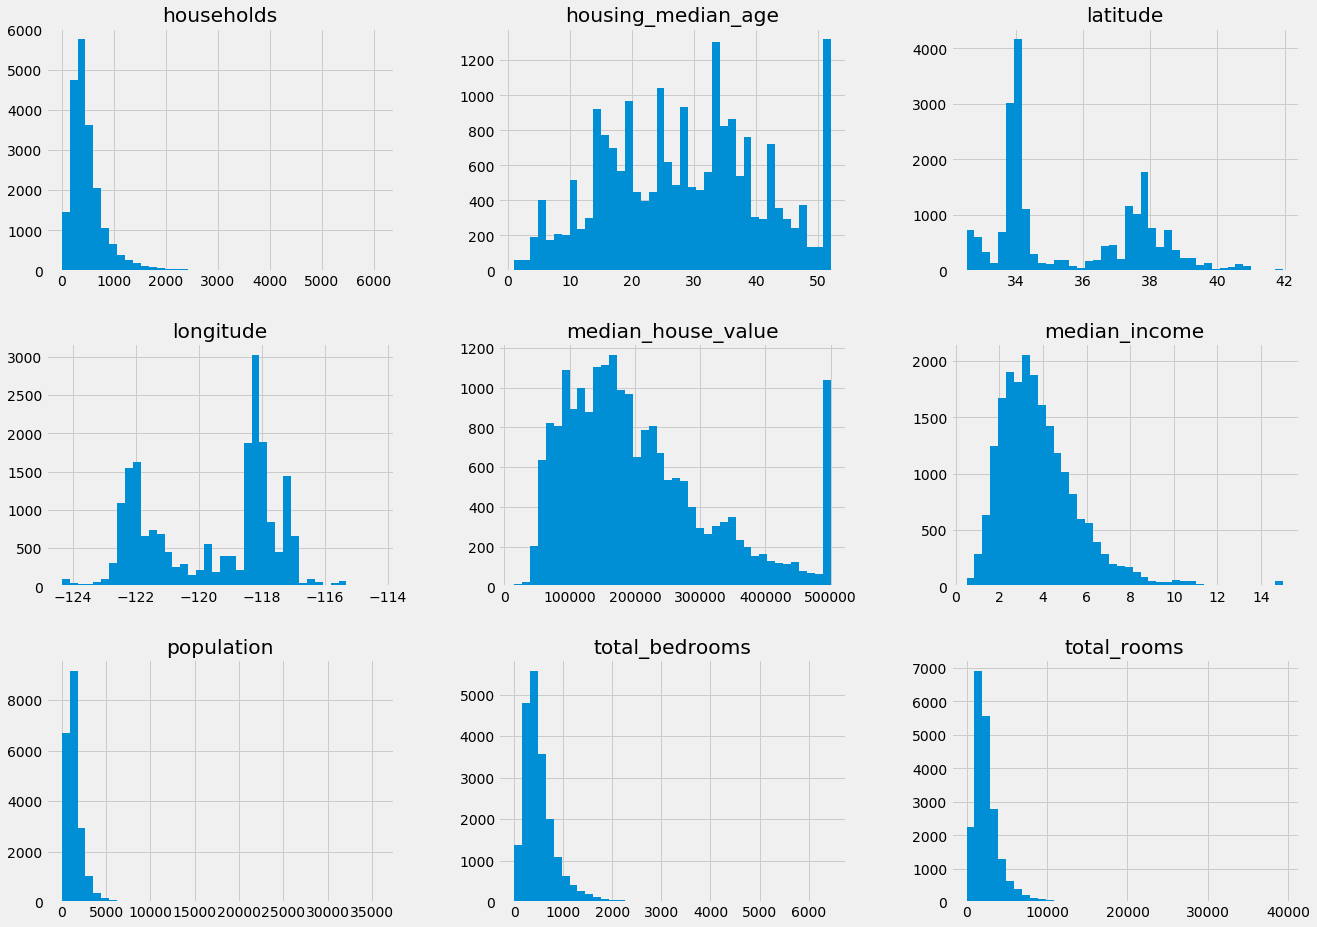

In [10]:
dataset.hist(bins=40, figsize=(20,15))
plt.show()

### Spliting the data

Creating a test set where we just pick some instnces randomly typically 20% of the datatset, and set them aside.

In [11]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)* test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(dataset, 0.2)
print('Whole:',len(dataset),' = Train:',len(train_set),' + Test:',len(test_set))

Whole: 20640  = Train: 16512  + Test: 4128


While this is  good approach to splitting data, it is vunerable to reading in biases as everytime algorithm see the test set it becomes bias something we should avoid in the first place. Its basically going to break everytime you update the dataset as the data that was in the test set will end up in the trainning set once we update tshe data

The other approach available is to try and use the index/identifier column to build  

In [13]:
import hashlib

In [34]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [35]:
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [36]:
dataset_with_id = dataset.reset_index()
train_set, test_set = split_train_test_by_id(dataset_with_id, 0.2 ,"index")

In [41]:
dataset_with_id['id'] = dataset['longitude']*1000+dataset['latitude']
train_set, test_set = split_train_test_by_id(dataset_with_id, 0.2, 'id')

In [42]:
dataset_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [43]:
from sklearn.model_selection import train_test_split
sk_train, sk_test_set = train_test_split(dataset, test_size=0.2, random_state=42)

In [50]:
dataset['income_cat']= np.ceil(dataset['median_income']/1.5)
dataset['income_cat'].where(dataset['income_cat'] < 5, 5.0, inplace=True)

In [51]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index, in split.split(dataset, dataset['income_cat']):
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]

In [53]:
dataset['income_cat'].value_counts()/len(dataset)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [54]:
for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis=1, inplace=True)

In [55]:
housing = strat_train_set.copy()

In [56]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


## Visualising the data to gain insights

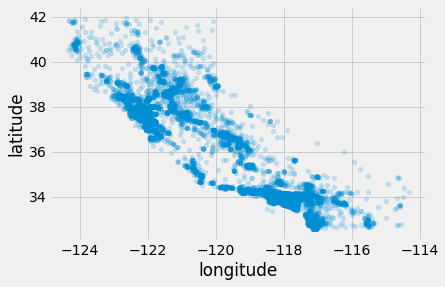

In [60]:
housing.plot(kind= 'scatter', x='longitude', y='latitude', alpha=.2)

ploting house prices the radius is the district population, and the color represents the price. cmap is predefined we choose jet 

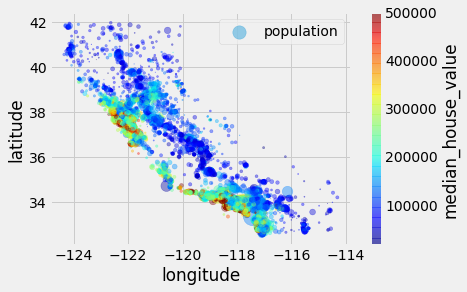

In [68]:
housing.plot(kind='scatter', x= 'longitude', y= 'latitude', alpha=0.4,
            s=housing['population']/100, label='population', c='median_house_value',
           cmap=plt.get_cmap('jet'), colorbar=True)

plt.legend()


This image gives us the intuitive answer that the population density and location  drive the prices of the houses. But more analysis is required to confirm this because in some places it might not holdd true. 

### Looking for correlations


In [71]:
corr_matrix = housing.corr()

In [72]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [73]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


Lets use pandas scatter matrix to get some visuals on these correlations 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f216445c9e8>,
      dtype=object)

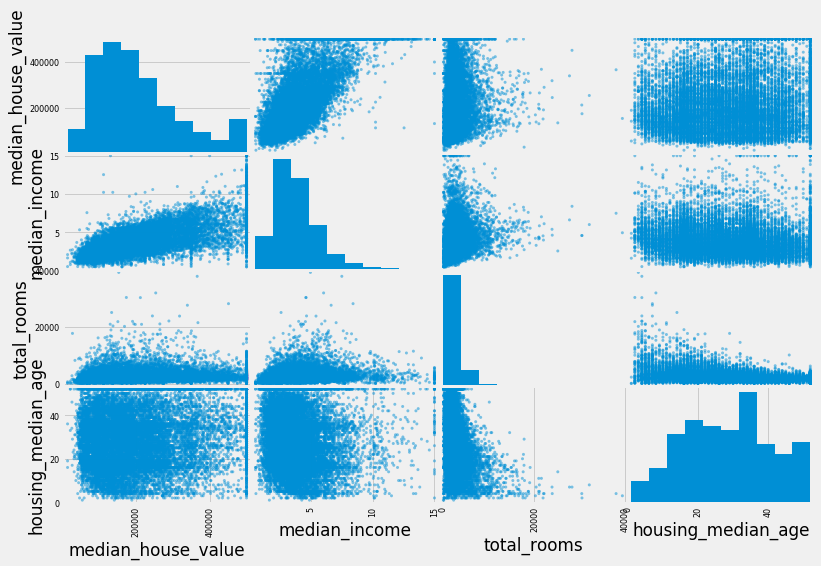

In [80]:
from pandas.plotting import scatter_matrix

attribute = [ 'median_house_value', 'median_income',
             'total_rooms', 'housing_median_age']
scatter_matrix(housing[attribute], figsize=(12,8))

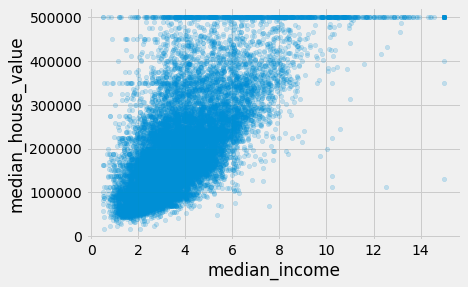

In [102]:

housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.2)

Thisplot shows that the correlation betwen the two attributes is indeed very strong but we also get to see some insights that we might have not focused on earlier e.g. The apparent caps _@_ 450000 and another one around 280000. We can try to remove some of the correspoding districts to limit the effects of the quirks on the model. 

#### Experimenting with Attribute Combinations

Trying out various attribute combinations. For example, the total number of rooms in the district is not very useful if you don't know how many households there are. 

In [103]:
housing['rooms_per_households'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [104]:
corr_matrix = housing.corr()

In [105]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_households        0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64